In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.
import os
for dirname, _, filenames in os.walk('recommendationsv4'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

recommendationsv4\meta_Grocery_and_Gourmet_Food.json
recommendationsv4\sample_submission.csv
recommendationsv4\test.csv
recommendationsv4\train.csv


In [2]:
import json
import nmslib
import pickle
import time
from sklearn.model_selection import train_test_split
import sklearn
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from lightfm import LightFM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
!pip freeze

alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
altair==4.1.0
anaconda-client==1.7.2
anaconda-navigator==2.0.3
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1610472525955/work
anyio @ file:///C:/ci/anyio_1620153418380/work/dist
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037959010/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astor==0.8.1
astroid @ file:///C:/ci/astroid_1613501047216/work
astropy @ file:///C:/ci/astropy_1617745647203/work
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1615918855173/work
Babel @ file:///tmp/build/80754af9/babel_1607110387436/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.functools-lru-cache @ file:///tmp/build/80754af9/backports.functools_lru_cache_1618170165463/work
bac

## Read_data

Загрузим данные, описывающие взаимодействие пользователя (user) и продукта (item), а также файл для сабмита

In [3]:
train = pd.read_csv('recommendationsv4/train.csv')
test = pd.read_csv('recommendationsv4/test.csv')
submission = pd.read_csv('recommendationsv4/sample_submission.csv')

C:\ProgramData\Anaconda33\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\ProgramData\Anaconda33\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Загрузим данные, описывающие характеристики товара 

In [4]:
meta = []
with open('recommendationsv4/meta_Grocery_and_Gourmet_Food.json', 'r') as file:
    for line in file:
        meta.append(json.loads(line))
file.close()
meta = pd.DataFrame(meta)

Посмотрим на тренировочный и тестовый датасеты:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


Можно видеть, что в train на три признака больше, чем в test. В test отсутствуют признаки **overall**, **reviewText**, **summary**, **rating**, но есть признак **Id**, которого нет в train. Посмотрим, есть ли дубликаты 

In [7]:
train, test.duplicated().sum()

(        overall  verified   reviewTime        asin            reviewerName  \
 0           5.0      True   10 4, 2016  B01CPNIEQG                 Heather   
 1           5.0      True   03 1, 2016  B006F63M8U              Linda Odom   
 2           5.0      True  06 26, 2016  B00112O8NG           DesertBlossom   
 3           5.0      True   09 5, 2013  B00MRAQUM8        Connie L. Reaves   
 4           5.0      True  09 14, 2016  B000R7RN0G                 Mike P.   
 ...         ...       ...          ...         ...                     ...   
 857890      5.0      True   04 2, 2013  B000H7ELTW              chezlouise   
 857891      2.0      True  12 13, 2015  B0012NI02O  Robert F. O&#039;Bryan   
 857892      4.0     False  09 21, 2016  B000LKX6R8            bamboo grove   
 857893      4.0      True   11 1, 2015  B00BUKL666              Speedway91   
 857894      5.0      True   08 3, 2017  B000JJHDVG     Elizabeth E. Castor   
 
                                                re

В тренировочном наборе есть 28960 дубликатов (удалим их), тестовый набор дубликатов не содержит

In [8]:
train.drop_duplicates(inplace=True)

In [9]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275787 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


Для удобства дальнейшего анализа объединим train и meta по признаку asin: 

In [10]:
df = pd.merge(train, meta, on='asin')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  float64
 1   verified        847593 non-null  bool   
 2   reviewTime      847593 non-null  object 
 3   asin            847593 non-null  object 
 4   reviewerName    847425 non-null  object 
 5   reviewText      847315 non-null  object 
 6   summary         847426 non-null  object 
 7   unixReviewTime  847593 non-null  int64  
 8   vote            118861 non-null  object 
 9   style           440351 non-null  object 
 10  image_x         7138 non-null    object 
 11  userid          847593 non-null  int64  
 12  itemid          847593 non-null  int64  
 13  rating          847593 non-null  float64
 14  category        847593 non-null  object 
 15  description     776098 non-null  object 
 16  title           847593 non-null  object 
 17  brand     

Получили всего 30 признаков, из них 5 - числового типа, 1 - логического, остальные - категориальные. 

Посмотрим на них более подробно, сразу отметим, что анализ поверхностный, ибо большинство признаков не используются для построения модели в дальнейшем, за исключением **userid**, **itemid** и **rating**

## EDA 

### 1. overall

In [12]:
def column_info(name, hist_draw=True):
    data = df[name]
    print(data.describe())
    print(f"\nNAN-values: {data.isnull().sum()}\n")
    print(f"Values:\n{data.value_counts(normalize = True)}\n")
    if hist_draw:
        data.hist()

count    847593.000000
mean          4.441068
std           1.065026
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

NAN-values: 0

Values:
5.0    0.716764
4.0    0.131983
3.0    0.070547
1.0    0.043737
2.0    0.036969
Name: overall, dtype: float64



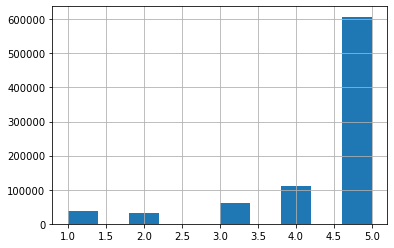

In [13]:
column_info("overall")

Скорее всего, это оценка по пятибальной шкале. Большинство (84%) отзывов положительные (оценка 4 или 5). Пропусков нет.

### 2. verified 

In [14]:
column_info("verified", hist_draw=False)

count     847593
unique         2
top         True
freq      736369
Name: verified, dtype: object

NAN-values: 0

Values:
True     0.868777
False    0.131223
Name: verified, dtype: float64



Вероятно, этот признак обозначает наличие подтверждения отзыва (возможно, отзывы проходят проверку). Пропусков нет, большинство (86%) отзывов подтвержденные.

### 3. reviewTime 

In [15]:
column_info("reviewTime", hist_draw=False)

count         847593
unique          4580
top       03 1, 2016
freq             941
Name: reviewTime, dtype: object

NAN-values: 0

Values:
03 1, 2016     0.001110
07 14, 2016    0.001030
01 20, 2016    0.000924
06 3, 2015     0.000924
02 20, 2016    0.000905
                 ...   
01 13, 2006    0.000001
05 7, 2006     0.000001
11 28, 2006    0.000001
08 20, 2007    0.000001
06 3, 2006     0.000001
Name: reviewTime, Length: 4580, dtype: float64



Дата отзыва, есть аналог в признаке unixReviewTime. Пропусков нет. 

### 4. asin

In [16]:
column_info("asin", hist_draw=False)

count         847593
unique         41302
top       B00BUKL666
freq            5430
Name: asin, dtype: object

NAN-values: 0

Values:
B00BUKL666    0.006406
B00D3M2QP4    0.005584
B008QMX2SG    0.005440
B0001LO3FG    0.005017
B00R7PWK7W    0.002889
                ...   
B0055SMXLG    0.000001
B00FKZTBBO    0.000001
B007JZRLHE    0.000001
B00OB9B2EO    0.000001
B01FWPF840    0.000001
Name: asin, Length: 41302, dtype: float64



Уникальный идентификатор товара (Amazon Standard Identification Number). Пропусков нет. Количество товаров, представленных в датасете 41302. 

### 5. reviewerName

In [17]:
column_info("reviewerName", hist_draw=False)

count              847425
unique             101207
top       Amazon Customer
freq                31346
Name: reviewerName, dtype: object

NAN-values: 168

Values:
Amazon Customer      0.036990
Kindle Customer      0.007231
Linda                0.000860
John                 0.000843
David                0.000715
                       ...   
Light Up My Life     0.000001
Hannah Henning       0.000001
Patricia Robinett    0.000001
VorpahlFam           0.000001
James Pappas         0.000001
Name: reviewerName, Length: 101207, dtype: float64



Имя покупателя. Есть пропуски. Наиболее часто встречающиеся имена Amazon и Kindle customer, что, скорее всего, является значением по умолчанию для случая, когда покупатель захотел остаться неизвестным.  

### 6. reviewText

In [18]:
column_info("reviewText", hist_draw=False)

count     847315
unique    686739
top         good
freq        3071
Name: reviewText, dtype: object

NAN-values: 278

Values:
good                                                                                                                                                                                     0.003624
great                                                                                                                                                                                    0.003069
Great                                                                                                                                                                                    0.002424
Good                                                                                                                                                                                     0.002379
ok                                                                                                

Отзыв покупателя. Есть пропуски. Наиболее популярные отзывы good, great, ok. 

### 7. summary 

In [19]:
column_info("summary", hist_draw=False)

count         847426
unique        411451
top       Five Stars
freq          171328
Name: summary, dtype: object

NAN-values: 167

Values:
Five Stars                                                                                0.202175
Four Stars                                                                                0.031386
Three Stars                                                                               0.014058
One Star                                                                                  0.006254
Two Stars                                                                                 0.005806
                                                                                            ...   
Heavenly !!!                                                                              0.000001
great looking and tasting garlic                                                          0.000001
Excellent.  Don't price gouge us.                                    

Краткое резюме покупателя. Есть пропуски. Наиболее популярные это количество звезд (от 1 до 5). 

### 8. unixReviewTime

count    8.475930e+05
mean     1.441914e+09
std      5.992384e+07
min      9.657792e+08
25%      1.412122e+09
50%      1.449360e+09
75%      1.485130e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64

NAN-values: 0

Values:
1456790400    0.001110
1468454400    0.001030
1433289600    0.000924
1453248000    0.000924
1455926400    0.000905
                ...   
1144972800    0.000001
1114041600    0.000001
1190419200    0.000001
1161734400    0.000001
1185408000    0.000001
Name: unixReviewTime, Length: 4580, dtype: float64



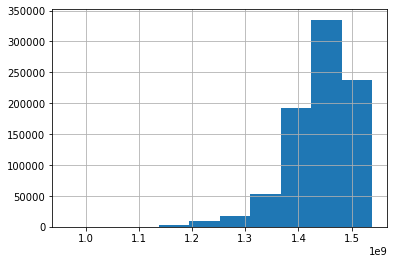

In [20]:
column_info("unixReviewTime")

Время отзыва в формате unixtime. Пропусков нет. Распределение показывает, что количество отзывов росло с течением времени, достигло своего максимума и пошло на спад. 

### 9. vote

In [21]:
column_info("vote", hist_draw=False)

count     118861.0
unique       477.0
top            2.0
freq       30774.0
Name: vote, dtype: float64

NAN-values: 728732

Values:
2.0      0.258907
3.0      0.129025
2        0.115984
4.0      0.074818
3        0.058632
           ...   
659.0    0.000008
334      0.000008
644.0    0.000008
603.0    0.000008
203.0    0.000008
Name: vote, Length: 477, dtype: float64



Скорее всего, это количество лайков на отзыв. Наблюдается много пропусков, что вполне естественно.

### 10. style

In [22]:
column_info("style", hist_draw=False)

count                      440351
unique                      25892
top       {'Size:': ' Pack of 1'}
freq                         4856
Name: style, dtype: object

NAN-values: 407242

Values:
{'Size:': ' Pack of 1'}                                    0.011028
{'Package Quantity:': ' 1'}                                0.010278
{'Package Type:': ' Standard Packaging'}                   0.008852
{'Size:': ' 1 Pack'}                                       0.008738
{'Size:': ' 24 Count'}                                     0.008266
                                                             ...   
{'Flavor:': ' Cayenne Veracruz Orange'}                    0.000002
{'Size:': ' 10.68 ounce', 'Flavor:': ' Caramel Peanut'}    0.000002
{'Flavor:': ' Plantain Strips Naturally Sweet'}            0.000002
{'Size:': ' 4 Count', 'Flavor:': ' Bold Creole'}           0.000002
{'Size:': ' 3 Ounce', 'Flavor:': ' Cinnamon'}              0.000002
Name: style, Length: 25892, dtype: float64



Признак содержит размер содержимого (количества единиц товара в упаковке или массу), а также характеристику вкуса. Имеются пропуски, кроме того, некоторые содержат только размер или только характеристику вкуса. 

### 11. image_x

In [23]:
column_info("image_x", hist_draw=False)

count                                                  7138
unique                                                 6636
top       ['https://images-na.ssl-images-amazon.com/imag...
freq                                                      6
Name: image_x, dtype: object

NAN-values: 840455

Values:
['https://images-na.ssl-images-amazon.com/images/I/712zJIOTV5L._SY88.jpg']                                                                                                                                                                                                                                  0.000841
['https://images-na.ssl-images-amazon.com/images/I/71+Z1TA3eyL._SY88.jpg']                                                                                                                                                                                                                                  0.000841
['https://images-na.ssl-images-amazon.com/images/I/81h8Zc+1rzL._SY88.jpg']          

Признак содержит ссылку на изображение товара. Много пропусков. 

### 12. userid

In [24]:
column_info("userid", hist_draw=False)

count    847593.000000
mean      53756.091163
std       37211.809152
min           0.000000
25%       20347.000000
50%       48581.000000
75%       84723.000000
max      127495.000000
Name: userid, dtype: float64

NAN-values: 0

Values:
842       0.000504
17987     0.000374
355       0.000356
2024      0.000349
2809      0.000329
            ...   
112150    0.000001
82011     0.000001
32867     0.000001
109270    0.000001
125701    0.000001
Name: userid, Length: 127448, dtype: float64



In [25]:
df.userid.nunique()

127448

Id пользователя. Пропусков нет. Всего 127448 уникальных значений. 

### 13. itemid

In [26]:
column_info("itemid", hist_draw=False)

count    847593.00000
mean      17090.10489
std       11584.74670
min           0.00000
25%        6478.00000
50%       16108.00000
75%       26719.00000
max       41319.00000
Name: itemid, dtype: float64

NAN-values: 0

Values:
22208    0.006406
23540    0.005584
24556    0.005440
379      0.005017
32046    0.002889
           ...   
38602    0.000001
40366    0.000001
39236    0.000001
16638    0.000001
6440     0.000001
Name: itemid, Length: 41302, dtype: float64



In [27]:
df.itemid.nunique()

41302

Id товара. Пропусков нет. Всего 41302 значения. 

### 14. rating

count    847593.000000
mean          0.848747
std           0.358296
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64

NAN-values: 0

Values:
1.0    0.848747
0.0    0.151253
Name: rating, dtype: float64



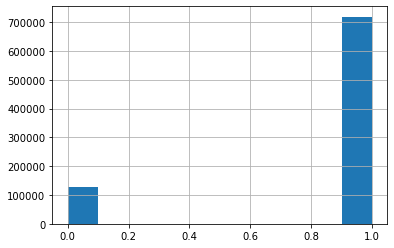

In [28]:
column_info("rating")

In [29]:
df[df.rating == 0].overall.value_counts(
), df[df.rating == 1].overall.value_counts()

(3.0    59795
 1.0    37071
 2.0    31335
 Name: overall, dtype: int64,
 5.0    607524
 4.0    111868
 Name: overall, dtype: int64)

Целевая переменная. Пропусков нет. 1 - товар понравился пользователю (оценка 4 или 5), 0 - не понравился(оценка 3, 2 и 1). 

### 15. category

In [30]:
all_values = []
for cat_list in df.category:
    for cat in cat_list:
        all_values.append(cat)
all_values = pd.DataFrame(all_values, columns=["category"])

In [31]:
all_values.category.nunique(), all_values.category.value_counts()

(1003,
 Grocery & Gourmet Food    847593
 Beverages                 226683
 Coffee, Tea & Cocoa       177340
 Cooking & Baking          164362
 Snack Foods               105355
                            ...  
 Tenderloins                    4
 Havarti                        3
 Sofrito Sauce                  3
 Tomatillos                     2
 Tulips                         2
 Name: category, Length: 1003, dtype: int64)

Признак содержит категории, к которым относится товар, всего имеется 1003 категории, наиболее часто встречающаяся - Grocery & Gourmet Food. 

### 16. description

In [32]:
df.description[100]

['Torani Vanilla Syrup, Sugar Free, 25.4 Fl Oz',
 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.']

Описание товара, есть пропуски.

In [33]:
df.description.isna().sum()

71495

### 17. title

In [34]:
column_info("title", hist_draw=False)

count                                                847593
unique                                                41149
top       KIND Bars, Dark Chocolate Nuts & Sea Salt, Glu...
freq                                                   7435
Name: title, dtype: object

NAN-values: 0

Values:
KIND Bars, Dark Chocolate Nuts & Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Название товара. Пропусков нет. 41149 уникальных значений.

### 18. brand

In [35]:
column_info("brand", hist_draw=False)

count     841489
unique      8866
top         KIND
freq       22506
Name: brand, dtype: object

NAN-values: 6104

Values:
KIND                            0.026745
Bob's Red Mill                  0.015521
Twinings                        0.013288
Planters                        0.012340
Frontier                        0.008231
                                  ...   
Coco Lite Muligrn Pop Cakes     0.000001
red dates                       0.000001
Drink Chia                      0.000001
DELICITALY Pure Italian Food    0.000001
Caf Indulgencia                 0.000001
Name: brand, Length: 8866, dtype: float64



Марка товара (бренд). Есть пропущенные значения. Самая популярная марка - KIND. 

### 19. rank

In [36]:
df["rank"]

0          19,771inGroceryGourmetFood(
1          19,771inGroceryGourmetFood(
2          19,771inGroceryGourmetFood(
3          19,771inGroceryGourmetFood(
4          19,771inGroceryGourmetFood(
                      ...             
847588    212,433inGroceryGourmetFood(
847589    150,108inGroceryGourmetFood(
847590     14,497inGroceryGourmetFood(
847591       443,322inHealthHousehold(
847592     43,444inGroceryGourmetFood(
Name: rank, Length: 847593, dtype: object

In [37]:
df["rank"].isna().sum()

34598

Ранг товара в соответствующей категории. Есть пропуски. 

### 20. also_view

In [38]:
df.also_view.isna().sum(), df.also_view[98]

(384222, ['B006K3UC86', 'B000WGB3OY'])

Рекомендации для товара (с этим товаром часто смотрят...) в виде списка asin, есть пропуски. 

### 21. main_cat

In [39]:
column_info("main_cat", hist_draw=False)

count      846638
unique         17
top       Grocery
freq       802613
Name: main_cat, dtype: object

NAN-values: 955

Values:
Grocery                      0.948000
Health & Personal Care       0.037448
Amazon Home                  0.008720
All Beauty                   0.001798
Sports & Outdoors            0.001561
Industrial & Scientific      0.001065
Office Products              0.000745
Toys & Games                 0.000359
Pet Supplies                 0.000148
Tools & Home Improvement     0.000063
Baby                         0.000040
Arts, Crafts & Sewing        0.000022
Home Audio & Theater         0.000011
Camera & Photo               0.000009
Software                     0.000004
Musical Instruments          0.000004
Cell Phones & Accessories    0.000002
Name: main_cat, dtype: float64



Основная категория товара (всего 17 разновидностей), есть пропуски, самая популярная категория - Grocery.

### 22. price

In [40]:
column_info("price", hist_draw=False)

count     588972
unique      4601
top       $14.99
freq       14241
Name: price, dtype: object

NAN-values: 258621

Values:
$14.99              0.024179
$13.67              0.018099
$19.99              0.015354
$14.79              0.009562
$15.53              0.009442
                      ...   
$15.82              0.000003
$44.14              0.000002
$19.99 - $295.00    0.000002
$6.93               0.000002
$35.16              0.000002
Name: price, Length: 4601, dtype: float64



Стоимость товара в долларах, есть пропуски. 

### 23. also_buy

In [41]:
df.also_buy.isna().sum(), df.also_buy[987][0:5]

(120735,
 ['B000R7XBF2', 'B000HIFA8W', 'B000R7RODW', 'B07BDQGY1S', 'B072M1NC4M'])

Рекомендации для товара (с этим товаром часто покупают...) в виде списка asin, есть пропуски. 

### 24. image_y

In [42]:
df.image_y.isna().sum(), df.image_y[500]

(92239,
 ['https://images-na.ssl-images-amazon.com/images/I/315GMJ26auL._SS40_.jpg',
  'https://images-na.ssl-images-amazon.com/images/I/31pJAJhX22L._SS40_.jpg',
  'https://images-na.ssl-images-amazon.com/images/I/51UZ1D3htOL._SS40_.jpg',
  'https://images-na.ssl-images-amazon.com/images/I/5169QbtJl5L._SS40_.jpg'])

Ссылки на изображения товаров, есть пропуски. 

### 25. date

In [43]:
column_info("date", hist_draw=False)

count               12087
unique                417
top       January 1, 2006
freq                  561
Name: date, dtype: object

NAN-values: 835506

Values:
January 1, 2006      0.046414
May 5, 2003          0.035410
October 29, 2003     0.035079
January 7, 2008      0.030777
March 10, 2004       0.024324
                       ...   
December 21, 2007    0.000165
October 30, 2014     0.000165
February 13, 2008    0.000083
February 21, 2015    0.000083
January 18, 2008     0.000083
Name: date, Length: 417, dtype: float64



Признак даты отзыва в формате (месяц число, год), много пропусков

### 26. feature

In [44]:
df.feature.isna().sum()/df.shape[0]

0.8316007800913882

Дополнительные признаки, много пропусков.

### 27. details

In [45]:
df.details[0][0:300]

'\n      <div class="content">\n\n\n\n\n\n\n<ul>\n\n\n\n\n\n\n\n\n\n\n\n\n\n                                                                                \n\n\n    <li><b>\n    Product Dimensions: \n    </b>\n    1.8 x 4.5 x 1.8 inches ; 7.4 ounces\n    </li>\n\n\n\n\n\n\n\n\n<li><b>Shipping Weight:</b> 8 ounces (<a href="/gp/help/sell'

Дополнительный признак (похоже на код страницы в сети)

### 28. similar_item

In [46]:
df.similar_item.isna().sum()/df.shape[0]

0.998657374471002

Почти вся информация - пропуски

### 29. tech1


In [47]:
df.tech1.isna().sum()/df.shape[0]

0.9948418639606509

Почти вся информация - пропуски

### 30. fit

In [48]:
df.fit.isna().sum()/df.shape[0]

1.0

Вся информация - пропуски

Выясним, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента:

In [49]:
from itertools import combinations
from scipy.stats import ttest_ind

In [50]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'overall'],
                     df.loc[df.loc[:, column] == comb[1], 'overall']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [51]:
for col in ['verified', 'unixReviewTime', 'vote', 'rank', 'main_cat', 'price']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки vote
Найдены статистически значимые различия для колонки rank
Найдены статистически значимые различия для колонки main_cat
Найдены статистически значимые различия для колонки price


Как видно, статистическая разница обнаруживается для всех шести признаков, а значит, их можно включить в модель. 

### Выводы

Проведен EDA. Выбраны признаки, добавление которых в модель окажет положительное влияние на метрики. 

Признаки, которые можно взять в модель:

verified, price, rank, userid, itemid, rating, vote, unixReviewTime, main_cat